# Bayesian optimization integrating model hyper-parameters

In this notebook we are going to see how to use Emukit to solve optimization problems when the acquisition function is integrated with respect to the hyper-parameters of the model. 

To show this with an example, use the Six-hump camel function 

$$f(x_1,x_2) = \left(4-2.1x_1^2 = \frac{x_1^4}{3} \right)x_1^2 + x_1x_2 + (-4 +4x_2^2)x_2^2,$$

in $[-3,3]\times [-2,2]$. This functions has two global minima, at $(0.0898,-0.7126)$ and $(-0.0898,0.7126)$.



In [1]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Loading the problem and generate initial data

In [2]:
from emukit.test_functions import sixhumpcamel_function
f, parameter_space = sixhumpcamel_function()

Now we define the domain of the function to optimize.

In [3]:
### --- Generate data
from emukit.experimental_design.model_free.random_design import RandomDesign

design = RandomDesign(parameter_space) # Collect random points
num_data_points = 5
X = design.get_samples(num_data_points)
Y = f(X)

## Train the model on the initial data

In [5]:
import GPy

model_gpy_mcmc = GPy.models.GPRegression(X,Y)
model_gpy_mcmc.kern.set_prior(GPy.priors.Uniform(0,5))
model_gpy_mcmc.likelihood.variance.constrain_fixed(0.001)

reconstraining parameters GP_regression.rbf


array([0])

We wrap the model in Emukit.

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,"[0, 5]"
rbf.lengthscale,1.0,+ve,"[0, 5]"
Gaussian_noise.variance,0.001,+ve fixed,


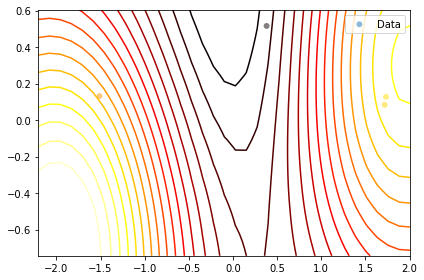

In [6]:
from emukit.model_wrappers import GPyModelWrapper
model_emukit = GPyModelWrapper(model_gpy_mcmc)
model_emukit.model.plot()
model_emukit.model

### Create the aquisition function

We just need to create the acquisition and the loop as usual in Emukit.

In [8]:
from emukit.bayesian_optimization.acquisitions import IntegratedExpectedImprovement
expected_improvement_integrated = IntegratedExpectedImprovement(model_emukit)

In [9]:
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop

bayesopt_loop = BayesianOptimizationLoop(model = model_emukit,
                                         space = parameter_space,
                                         acquisition = expected_improvement_integrated,
                                         batch_size = 1)

We run the loop for 10 iterations.

In [10]:
max_iter = 10
bayesopt_loop.run_loop(f, max_iter)

Optimization restart 1/1, f = 5.1154266199694
Optimization restart 1/1, f = 7.014390586629178
Optimization restart 1/1, f = 8.172046949717481
Optimization restart 1/1, f = 8.017308119497201
Optimization restart 1/1, f = 8.495161706056823
Optimization restart 1/1, f = 10.790766598112429
Optimization restart 1/1, f = 12.597847195665569
Optimization restart 1/1, f = 15.02534950245892
Optimization restart 1/1, f = 15.695909712651966
Optimization restart 1/1, f = 16.59848383854039
Optimization restart 1/1, f = 17.70509449949056


Now, once the loop is completed we can visualize the distribution of the hyperparameters given the data.

Text(0,0.5,'Frequency')

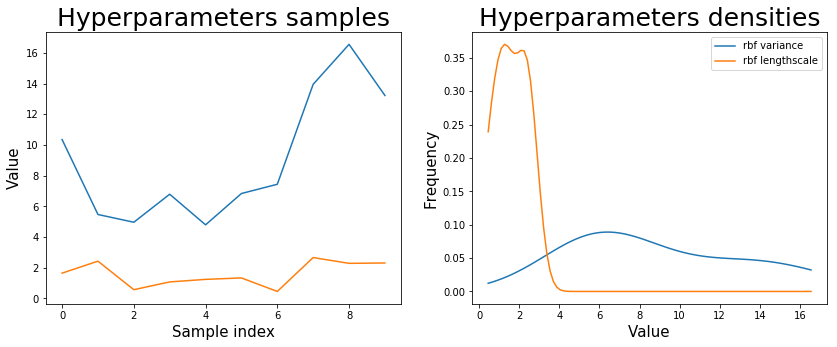

In [14]:
labels = ['rbf variance', 'rbf lengthscale']

plt.figure(figsize=(14,5))
samples = bayesopt_loop.candidate_point_calculator.acquisition.samples

plt.subplot(1,2,1)
plt.plot(samples,label = labels)
plt.title('Hyperparameters samples',size=25)
plt.xlabel('Sample index',size=15)
plt.ylabel('Value',size=15)

plt.subplot(1,2,2)
from scipy import stats
xmin = samples.min()
xmax = samples.max()
xs = np.linspace(xmin,xmax,100)
for i in range(samples.shape[1]):
    kernel = stats.gaussian_kde(samples[:,i])
    plot(xs,kernel(xs),label=labels[i])
_ = legend()
plt.title('Hyperparameters densities',size=25)
plt.xlabel('Value',size=15)
plt.ylabel('Frequency',size=15)

And we can check how the optimization evolved when you integrate out the acquisition.

Text(0.5,0,'Iteration')

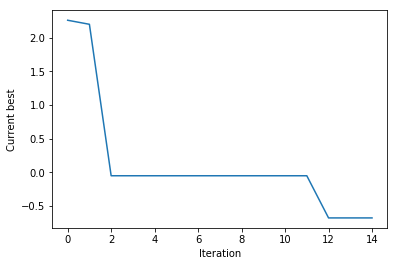

In [15]:
plt.plot(np.minimum.accumulate(bayesopt_loop.loop_state.Y))
plt.ylabel('Current best')
plt.xlabel('Iteration')